# Imports

In [1]:
import pickle
import os
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline

# Load Pickle Files

load the pickle files, audio_data is a list of arrays, where the arrays are of different shapes

In [2]:
allaudios = [] # Creates an empty list
for root, dirs, files in os.walk("train"):
    i=0 
    for file in files:
        if file.endswith(".pkl"):
            audio = file
            openaudios = open(os.getcwd() + "/train/" + audio, 'rb')
            loadedaudios = pickle.load(openaudios)
           
            allaudios.append(loadedaudios)
            i+=1
            if i==100:
                break

audio_data = []
valence = []
for audio in allaudios:
    audio_data.append(audio['audio_data'])
    valence.append(audio['valence'])

# Data Investigation

In [3]:
print(len(audio_data))
print(len(valence))

100
100


In [4]:
mean = np.mean(np.concatenate(audio_data))
mom = np.mean([np.mean(arr) for arr in audio_data]) # mean of means

std = np.std(np.concatenate(audio_data))
average_std = np.mean([np.std(arr) for arr in audio_data])

median_len = np.median([len(arr) for arr in audio_data])
mean_len = np.mean([len(arr) for arr in audio_data])
std_len = np.std([len(arr) for arr in audio_data])
min_len = np.min([len(arr) for arr in audio_data])
max_len = np.max([len(arr) for arr in audio_data])


print(f'Concatenated mean: {mean} \nMean of Means:{mom} \nConcatenated std: {std} \nAverage std per array {average_std}')
print(f'\nMean Lenght: {mean_len} \nMedian Length: {median_len} \nstd: {std_len}')
print(f'\nMin Length: {min_len} \nMax Length:{max_len}')

Concatenated mean: -2.056175253528636e-05 
Mean of Means:-1.2840777344536036e-05 
Concatenated std: 0.11892097443342209 
Average std per array 0.0921965092420578

Mean Lenght: 38951.38 
Median Length: 38076.0 
std: 20929.255396110013

Min Length: 9057 
Max Length:101728


does not max sense to go off max better to take mean or median 

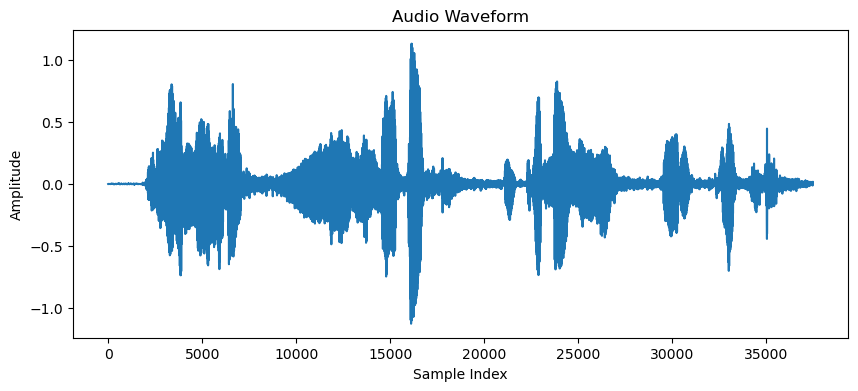

In [5]:
plt.figure(figsize=(10, 4))  # Specify the figure size
plt.plot(audio_data[10])    # Plot the audio data
plt.title('Audio Waveform')  # Set the title of the plot
plt.xlabel('Sample Index')   # Label for the x-axis
plt.ylabel('Amplitude')      # Label for the y-axis
plt.show()  

# Preprocess 

left trim, right trim, then do padding to the mean

In [6]:
def trim_sides(arr):
    first_non_zero = np.argmax(arr != 0)
    last_non_zero = len(arr) - np.argmax(arr[::-1] != 0)
    
    return arr[first_non_zero:last_non_zero]

## Normalization

volume could be indicator of valence should we normalize??

ensuring all input values are scaled uniformly to the range of -1 to 1.

In [7]:
class AmplitudeNormalization(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        with torch.no_grad():
            max_val = torch.max(torch.abs(x))
            x = x / max_val if max_val != 0 else x
        return x

In [8]:
class AmplitudeNormalization(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        with torch.no_grad():
            max_val = torch.max(torch.abs(x))
            x = x / max_val if max_val != 0 else x
        return x

In [9]:
class construct_mel_spectrogram(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        with torch.no_grad():
            # make a spectrogram using short-time Fourier transform
            spectrogram = librosa.stft(x)

            # separate the spectrogram into the magnitude and phase components
            spectrogram_mag_and_phase, _ = librosa.magphase(spectrogram)

            # compute the mel-scaled spectrogram - mel-scale takes into account how humans perceive frequencies
            mel_scale_spectrogram = librosa.feature.melspectrogram(S=spectrogram_mag_and_phase, sr=8000)

            # plot the results
            # librosa.display.specshow(mel_scale_spectrogram)

            # covert amplitude spectrogram to a dB-scaled spectrogram
            mel_spectrogram = librosa.amplitude_to_db(mel_scale_spectrogram, ref=np.min)
            
            # plot the results
            # librosa.display.specshow(mel_spectrogram, sr=8000, x_axis='time', y_axis='mel')
            # plt.colorbar(format='%+2.0f dB')
            
        return mel_spectrogram

# Train Test Data for Model

In [10]:
size_train = int(round(len(audio_data) * 0.8))
X_train = audio_data[:size_train]
X_test = audio_data[size_train:]
y_train = valence[:size_train]
y_test = valence[size_train:]

batch_size = 64

In [11]:
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [12]:
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True,) # you can speed up the host to device transfer by enabling pin_memory.
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True,) # you can speed up the host to device transfer by enabling pin_memory.



## use pad_trunc(arr self.duration) self.duration = desired length

In [71]:
def pad_trunc_audio(audio_data, target_length = int(np.percentile(audio_lengths, 95))):
    standardized_data = []
    for data in audio_data:
        if len(data) < target_length:
            padded_data = np.pad(data, (0, target_length - len(data)), 'constant', constant_values=(0, 0))
            standardized_data.append(padded_data)
        elif len(data) > target_length:
            truncated_data = data[:target_length]
            standardized_data.append(truncated_data)
        else:
            standardized_data.append(data)
    return standardized_data


In [73]:
standardized_audios = pad_trunc_audio(audio_data)


https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

# Model Setup

In [15]:
class CNN(nn.Module):
    def __init__(self, pre_proocesses, hidden_sizes, activation_function, linear_layer1_size, output_size):

        super(CNN, self).__init__()

        self.hidden_sizes = hidden_sizes
        self.activation_function = activation_function
        self.output_size = output_size
        self.linear_layer1_size = linear_layer1_size


        self.layers = nn.ModuleList()

        # add preprocessing steps
        for process in pre_proocesses:
            self.layers.append(process())

        for i in range(len(self.hidden_sizes)):
            self.layers.append(nn.Conv1d(1 if i ==0 else self.hidden_sizes[i-1], self.hidden_sizes[i], kernel_size=3))
            self.layers.append(nn.BatchNorm1d(self.hidden_sizes[i], eps=.00001, momentum=0.1, affine=True, track_running_stats=True))
            self.layers.append(nn.MaxPool1d(kernel_size=3))
            self.layers.append(self.activation_function())

        # self.layers.append(nn.AdaptiveAvgPool1d(1))
        self.layers.append(nn.Flatten()) 
        self.layers.append(nn.Linear(in_features=(self.hidden_sizes[-1]), out_features=self.linear_layer1_size, bias=True))
        self.layers.append(nn.Dropout(p=0.5))
        self.layers.append(nn.Linear(in_features=self.hidden_linear_output, out_features=self.output_size, bias=True))

    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

In [16]:
cnn_model = CNN(pre_proocesses=[construct_mel_spectrogram], hidden_sizes=[8, 16, 32, 64, 128], activation_function=nn.ReLU, linear_layer1_size=64, output_size=5)
print(cnn_model)

AttributeError: 'CNN' object has no attribute 'hidden_linear_output'

below is example of last year

In [ ]:
# Create the model

# increased depth of the network
n_filters = [1, 16, 16, 32, 32, 64, 64, 128, 128, 256]
classifier_width = 128
cnn_layers = []
output_size = 6

for n_in, n_out in zip(n_filters[:-1], n_filters[1:]):
    cnn_layers.append(nn.Conv1d(n_in, n_out, kernel_size=3))
    cnn_layers.append(nn.ReLU())
    cnn_layers.append(nn.MaxPool1d(kernel_size=3))

# adaptive average pooling to obtain features
cnn_layers.append(nn.AdaptiveAvgPool1d(1))
cnn_layers.append(nn.Flatten())
model = nn.Sequential(
    loudness_normalization,
    normalization,
    *cnn_layers,
    nn.Linear(n_filters[-1], classifier_width),
    nn.ReLU(),
    nn.Linear(classifier_width, classifier_width),
    nn.ReLU(),
    nn.Linear(classifier_width, output_size),
)
# No soft max as loss function expects logits

model = model.to(device)

In [78]:
def calculate_metrics(actual, predicted):

    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    
    return {
        "Mean Absolute Error (MAE)": mae,
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "R-squared (R^2)": r2
    }
